## MC
------------

Monte Carlo simulations are a powerful and versatile tool in portfolio optimization, offering a probabilistic approach to decision-making under uncertainty.
It simulations generate a wide range of possible future price scenarios for assets based on historical data, statistical models, or assumed distributions (e.g., normal distribution of returns), these scenarios incorporate randomness to reflect the uncertainty of real-world market movements. 
For each simulated scenario, portfolio metrics such as returns, volatility (standard deviation), and risk-adjusted measures (e.g., Sharpe ratio) are computed. The simulations provide a distribution of potential outcomes, enabling investors to assess the likelihood of achieving specific return or risk thresholds.
> The goal is to identify the "efficient frontier," which represents portfolios offering the highest expected return for a given level of risk

By simulating extreme market conditions, Monte Carlo methods allow for stress testing of portfolio resilience, this helps in understanding the potential impact of rare events (e.g., financial crises) and optimizing portfolios to withstand such shocks.

>By simulating numerous possible outcomes and exploring vast combinations of portfolio allocations, Monte Carlo methods enable investors to optimize portfolios that are resilient, efficient, and tailored to their risk-return profiles.


---------
> SIMULATE FUTURE ASSET PRICES

> ESTIMATE PORTFOLIO METRICS

> EXPLOR THE EFFICIENT FRONTIER

> STRESS TESTING SCENARIO ANALYSIS

> DYNAMIC REBALANCING

---
hidden info
<risk assessment> 
<optimizating risk adjusted returns>
<incorporating nonlinear constrains>
<forcasting correlations and diversification>
<evaluating alternative strategies>
<sensitivity analysis>

---
### MODERN PORTFOLIO THEORY

The Sharpe ratio compares the return of an investment with its risk. It's a mathematical expression of the insight that excess returns over a period of time may signify more volatility and risk, rather than investing skill

---
# BIBLIOTECAS

In [36]:
import numpy as np
import pandas as pd
#from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import datetime as dt
from scipy.optimize import minimize
#from stock_forecasting.config import PROCESSED_DATA_DIR
import pickle

In [ ]:
%pip install setuptools==62.0.0 wheel

In [ ]:
%pip install --upgrade pip

In [ ]:
%pip install -e ..

In [ ]:
from stock_forecasting.features import *
from stock_forecasting.plots import *
from stock_forecasting.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR
from stock_forecasting.modeling.train import train_lstm, predict

In [4]:
%pwd

'c:\\Users\\Daniela\\Desktop\\Fac\\3ºano\\Lab_IACD\\Project2\\stocks-prediction-labia\\notebooks'

In [37]:
from pathlib import Path

PROJ_ROOT = Path('c:\\Users\\Daniela\\Desktop\\Fac\\3ºano\\Lab_IACD\\Project2\\stocks-prediction-labia')
# logger.info(f"PROJ_ROOT path is: {PROJ_ROOT}")

DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
EXTERNAL_DATA_DIR = DATA_DIR / "external"
MODELS_DIR = PROJ_ROOT / "models"

In [5]:
df = pdr.DataReader('^SPX', data_source='stooq', start='2010-1-1', end='2023-12-31')

---
## Using Both Historical and Predicted Data
 ### HISTORICAL DATA
 Use it to estimate parameters like volatility, correlations, and historical patterns of returns
 Generate baseline Monte Carlo simulations for comparison
 ### PREDICTED DATA
 Integrate LSTM predictions for January 2024 into the Monte Carlo framework as the expected mean return or as one of the scenarios.
 Use these predictions to adjust simulations for expected future trends.
 ### Hybrid Approach:
 Combine the two by using historical data for broader context and volatility modeling, while integrating LSTM predictions as a factor influencing January 2024's specific simulations.
        
---

### Estimate Parameters: 
historical data (2010–2023) to compute volatility, correlations, and average returns

calculate mean return and standard diviation

estimate the correlation matrix for all stocks

In [38]:
with open(PROCESSED_DATA_DIR / "filtered.pkl", "rb") as  f:
    fuu = pickle.load(f)

print(fuu)

Ticker                           HAL                                   \
Price                           Open       High        Low      Close   
Date                                                                    
2010-01-04 00:00:00+00:00  24.386298  24.878470  24.338669  24.807026   
2010-01-05 00:00:00+00:00  24.830845  25.267448  24.600635  25.124559   
2010-01-06 00:00:00+00:00  25.196001  25.870752  25.116618  25.719927   
2010-01-07 00:00:00+00:00  25.648485  25.815188  25.338892  25.783434   
2010-01-08 00:00:00+00:00  26.156536  27.101187  25.791377  27.085310   
...                              ...        ...        ...        ...   
2024-01-24 00:00:00+00:00  35.128161  36.378519  34.931253  36.260376   
2024-01-25 00:00:00+00:00  36.506506  36.673875  35.443208  36.427742   
2024-01-26 00:00:00+00:00  36.299751  37.274441  36.191452  36.949543   
2024-01-29 00:00:00+00:00  36.673877  36.782176  36.201301  36.614803   
2024-01-30 00:00:00+00:00  35.393981  36.437584  34

In [17]:

fuu = fuu.xs("Close", level="Price", axis=1).pct_change()
fuu = fuu[fuu.index < "2024-01-01"]
print(fuu)

Ticker                          HAL         K       IRM       HES       KEY  \
Date                                                                          
2010-01-04 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   
2010-01-05 00:00:00+00:00  0.012800  0.002271  0.003058  0.006175  0.038721   
2010-01-06 00:00:00+00:00  0.023697  0.000189  0.032230  0.002675 -0.006483   
2010-01-07 00:00:00+00:00  0.002469  0.009819  0.016033  0.019146  0.042414   
2010-01-08 00:00:00+00:00  0.050493 -0.001870  0.002907  0.013705  0.017215   
...                             ...       ...       ...       ...       ...   
2023-12-22 00:00:00+00:00 -0.001365  0.011699  0.004634  0.002805  0.000700   
2023-12-26 00:00:00+00:00  0.012572  0.009545  0.007208  0.014124  0.011197   
2023-12-27 00:00:00+00:00 -0.010526  0.003091  0.005295 -0.000337  0.004844   
2023-12-28 00:00:00+00:00 -0.012275  0.008157  0.005125 -0.025845  0.001377   
2023-12-29 00:00:00+00:00 -0.001657  0.005214 -0.008

In [ ]:
''' 
NOTAS:
 -retirar os valores de 2024
 -talvez fosse útil guardar desvio padrão de tudo e desvio padrão do ano passado(2023)
  [total, 2023]
'''

def get_data():
    stockData = pd.read_pickle(PROCESSED_DATA_DIR / "filtered.pkl")
    returns = stockData.xs("Close", level="Price", axis=1).pct_change()
    returns = returns[returns.index < "2024-01-01"]
    meanReturns = returns.mean() #mu
    sigma = np.sqrt(returns.var()) #desvio padrão
    covMatrix = returns.cov() 
    return meanReturns, sigma,  covMatrix



meanReturns, sigma, covMatrix = get_data()

print(meanReturns)
print(sigma)

#give random weights to portfolio
''' '''
weights = np.random.random(len(meanReturns))
weights/=np.sum(weights)

#print(weights)



Ticker
HAL     0.000485
K       0.000239
IRM     0.000742
HES     0.000628
KEY     0.000651
          ...   
DLR     0.000587
DD      0.000475
SWK     0.000471
MSFT    0.000921
ROK     0.000795
Length: 392, dtype: float64
Ticker
HAL     0.027385
K       0.012232
IRM     0.017784
HES     0.025903
KEY     0.023644
          ...   
DLR     0.016924
DD      0.019726
SWK     0.020148
MSFT    0.016334
ROK     0.018937
Length: 392, dtype: float64
[2.39104734e-03 1.40549790e-03 2.96467142e-03 4.16026620e-03
 3.78844307e-03 4.57906023e-03 3.12184604e-03 4.87688520e-03
 1.18876554e-03 8.52555554e-04 3.89495614e-03 2.88521713e-03
 2.52083422e-03 5.78526963e-04 4.06886281e-03 4.15152661e-03
 4.02704133e-03 7.63612883e-04 2.13000943e-03 4.56038283e-03
 3.48832579e-03 3.71883814e-03 1.54408390e-03 3.87339709e-03
 2.04260428e-03 1.68097008e-03 3.86090064e-03 1.10798261e-03
 1.56579199e-03 5.93008186e-05 4.38637765e-04 1.63368482e-04
 1.24581951e-03 2.99488809e-03 5.74600136e-04 7.11353387e-04
 1.2931

In [ ]:
print(np.array(covMatrix)[0][0])  #2D

0.0007474365355792281


In [40]:

with open(MODELS_DIR / "predictions.pkl", "rb") as  f:
    foo = pickle.load(f)

print(foo)

                                    A        AAPL         ABT       ACGL  \
Date                                                                       
2024-01-02 00:00:00+00:00  137.876383  184.498739  107.863139  71.822264   
2024-01-03 00:00:00+00:00  137.802864  184.481583  108.200438  71.760927   
2024-01-04 00:00:00+00:00  137.727084  184.586661  108.646210  71.872957   
2024-01-05 00:00:00+00:00  137.305715  184.203784  108.902665  71.778654   
2024-01-08 00:00:00+00:00  137.369698  184.324842  109.316175  71.865984   
2024-01-09 00:00:00+00:00  130.197189  184.434440  111.035987  72.544258   
2024-01-10 00:00:00+00:00  130.265698  184.557079  111.488240  72.622080   
2024-01-11 00:00:00+00:00  130.385192  184.779113  112.002845  72.774941   
2024-01-12 00:00:00+00:00  130.199638  184.381166  112.277772  72.745835   
2024-01-16 00:00:00+00:00  130.267232  184.458294  112.653409  72.790322   
2024-01-17 00:00:00+00:00  127.359354  181.587067  112.428299  74.821923   
2024-01-18 0

In [26]:
print( len(meanReturns), len(weights))

392 392


In [5]:
def get_data():
    stockData = pd.read_pickle(PROCESSED_DATA_DIR / "filtered.pkl")
    returns = stockData.xs("Close", level="Price", axis=1).pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    
    stock_data = {}
    for stock in meanReturns.index:
        stock_data[stock] = {
            "mu": meanReturns[stock],
            "sigma": covMatrix.loc[stock, stock] ** 0.5  # Standard deviation (sqrt of variance)
        }
    
    return stock_data, covMatrix

stock_data, covMatrix = get_data()
print(stock_data)


{'HAL': {'mu': np.float64(0.00048827312712713673), 'sigma': np.float64(0.027339285571851144)}, 'K': {'mu': np.float64(0.00023492320535226183), 'sigma': np.float64(0.01223613461837201)}, 'IRM': {'mu': np.float64(0.0007315678875055231), 'sigma': np.float64(0.017768281789662155)}, 'HES': {'mu': np.float64(0.0006238647546020997), 'sigma': np.float64(0.02585001081434251)}, 'KEY': {'mu': np.float64(0.0006600816343582671), 'sigma': np.float64(0.02362855728429143)}, 'DGX': {'mu': np.float64(0.0003879355575433804), 'sigma': np.float64(0.014499816200067383)}, 'TER': {'mu': np.float64(0.0009450044033365267), 'sigma': np.float64(0.023940249735752483)}, 'YUM': {'mu': np.float64(0.0006553712804579503), 'sigma': np.float64(0.01513756733009235)}, 'GRMN': {'mu': np.float64(0.0006642988471275877), 'sigma': np.float64(0.017154799710611474)}, 'ARE': {'mu': np.float64(0.0004295333245273395), 'sigma': np.float64(0.01581076181470907)}, 'BALL': {'mu': np.float64(0.0005779446670134328), 'sigma': np.float64(0.0

#### Instead of using random weigths you can have them based on:

-annual volatility

-minimum variance portfolio

-ERC(Equal Risk Contribution) : Assign weights so that each asset contributes equally to portfolio risk. This is a more advanced form of risk parity. 
the idea of the strategy is to find a risk-balanced portfolio such that the risk contribution is the same for all assets of the portfolio

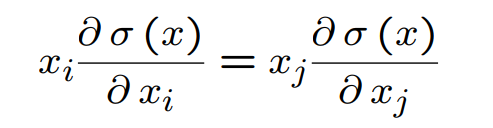

The ERC portfolio may be viewed as a portfolio “between” the 1/n portfolio(in this case annual volatility) and the minimum variance portfolio.


In [35]:
weights = weights
print(len(weights))

data = fuu
covariance = covMatrix

portfolio_variance = (weights@covariance@weights.T) #<[0][0]
sigma = sigma
marginal_risk = covariance@weights.T
risk_contribution = np.multiply(marginal_risk, weights.T)/sigma
risk_contribution_2 = np.multiply(marginal_risk, weights.T)/np.sqrt(portfolio_variance)
print(risk_contribution, risk_contribution_2)

392
Ticker
HAL     0.000019
K       0.000011
IRM     0.000017
HES     0.000018
KEY     0.000021
          ...   
DLR     0.000015
DD      0.000022
SWK     0.000022
MSFT    0.000019
ROK     0.000022
Length: 392, dtype: float64 Ticker
HAL     0.000044
K       0.000012
IRM     0.000026
HES     0.000040
KEY     0.000044
          ...   
DLR     0.000022
DD      0.000037
SWK     0.000039
MSFT    0.000028
ROK     0.000036
Length: 392, dtype: float64


In [ ]:
#weights based on anual volatility

raw_data = pd.read_pickle(RAW_DATA_DIR / "raw.pkl")
raw_data = delete_recent(raw_data, threshold=0)
stats = calculate_stock_stats(raw_data)
volatilities = stats["annual_volatility"]

# Invert volatilities
#give more importance to the more stable
inv_vol = 1 / (volatilities + 1e-8) #in case volatilities is 0(not a thig but to be safe)
weights = inv_vol / inv_vol.sum() #ajust so that sum is 1

In [ ]:
#minimum variance portfolio

def minimum_variance_portfolio(cov_matrix):
    n = cov_matrix.shape[0]
    
    # Objective function: portfolio variance
    def portfolio_variance(w):
        return w.T @ cov_matrix @ w
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: no short-selling (weights >= 0)
    bounds = [(0, 1) for _ in range(n)]
    
    # Initial guess: equal weights
    init_weights = np.ones(n) / n
    
    # Solve optimization problem
    result = minimize(portfolio_variance, init_weights, bounds=bounds, constraints=constraints)
    return result.x

# Compute weights for the minimum variance portfolio
weights = minimum_variance_portfolio(covMatrix)

print("Minimum Variance Portfolio Weights:", weights)


In [ ]:
#ERC


def calculate_erc_weights(cov_matrix):
    n = cov_matrix.shape[0]
    
    # Objective function to minimize: squared differences in risk contributions
    def objective(w):
        portfolio_vol = np.sqrt(w.T @ cov_matrix @ w)
        marginal_contributions = cov_matrix @ w
        risk_contributions = w * marginal_contributions / portfolio_vol
        # Target: all risk contributions should be equal
        target = portfolio_vol / n
        return np.sum((risk_contributions - target) ** 2)

    # Initial guess: equal weights
    init_weights = np.ones(n) / n
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: no short-selling (weights >= 0)
    bounds = [(0, 1) for _ in range(n)]
    
    # Solve optimization
    result = minimize(objective, init_weights, bounds=bounds, constraints=constraints)
    return result.x


weights = calculate_erc_weights(covMatrix)

print("ERC Weights:", weights)


In [ ]:

def risk_contribution(weights, covariance):
    """Calculate risk contribution of each asset."""
    portfolio_variance = (weights@covariance@weights.T) 
    marginal_risk = covariance@weights.T
    risk_contribution = np.multiply(marginal_risk, weights.T)/np.sqrt(portfolio_variance)
    print(risk_contribution)

def risk_parity_objective(weights, cov_matrix):
    """Objective function for ERC optimization."""
    # Calculate risk contributions
    contributions = risk_contribution(weights, cov_matrix)
    # Target: minimize squared differences from average contribution
    average_contribution = contributions.sum() / len(contributions)
    return np.sum((contributions - average_contribution) ** 2)

def get_erc_weights_3(cov_matrix):
    """Calculate ERC weights."""
    num_assets = cov_matrix.shape[0]
    initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
    bounds = [(0, 1) for _ in range(num_assets)]  # No short selling, weights between 0 and 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights sum to 1

    # Minimize the ERC objective function
    result = minimize(
        risk_parity_objective,
        initial_weights,
        args=(cov_matrix,),
        bounds=bounds,
        constraints=constraints,
    )
    return result.x  # Optimized weights

weights = get_erc_weights_3(covMatrix)

print("ERC Weights:", weights)

In [33]:
import numpy as np
from scipy.optimize import minimize

def calculate_erc_weights(cov_matrix):
    """
    Calculate Equal Risk Contribution (ERC) weights given a covariance matrix.
    
    Args:
        cov_matrix (np.ndarray): Covariance matrix of asset returns.
    
    Returns:
        np.ndarray: Portfolio weights.
    """
    n = cov_matrix.shape[0]
    
    # Initial weights (e.g., equal weights)
    init_weights = np.ones(n) / n
    
    # Risk contribution calculation
    def risk_contribution(weights):
        portfolio_variance = weights.T @ cov_matrix @ weights
        marginal_contributions = cov_matrix @ weights
        risk_contributions = weights * marginal_contributions / np.sqrt(portfolio_variance)
        return risk_contributions
    
    # Objective function: Minimize squared differences in risk contributions
    def objective(weights):
        rc = risk_contribution(weights)
        return np.sum((rc - rc.mean()) ** 2)
    
    # Constraints: Weights sum to 1 and non-negative weights
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n)]
    
    # Optimize
    result = minimize(objective, init_weights, constraints=constraints, bounds=bounds)
    
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization did not converge.")


# Covariance matrix of 3 assets (example)
cov_matrix =  np.array(covMatrix)
weights = calculate_erc_weights(cov_matrix)
print("ERC Weights:", weights)


ERC Weights: [0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00

----------------
### generate random scenarions

Multi-Asset Simulation for Portfolio Allocation is needed to acount for the different money alocation possibilities(vaious places to bit money into)

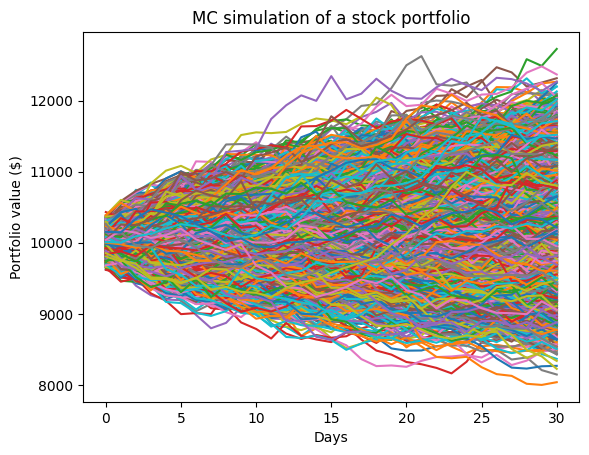

In [8]:
#MC simulater
#nº of simulations
mc_simes = 5001
T = 31 #days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T #transpose

portfolio_sins = np.full(shape=(T, mc_simes), fill_value=0.0)

initialPortfolio = 10000 #started with initialPortfolio money

for m in range(0, mc_simes):
    #mc loops
    Z = np.random.normal(size=(T, len(weights))) #T com o nº de stocks
    L = np.linalg.cholesky(covMatrix) #lower triangle // nº of stocks by the n of stocks 

    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sins[:, m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sins)
plt.ylabel('Portfolio value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


#### GBM(geometric Brownian motion)
- is a continuous-time stochastic process in which the logarithm of the randomly varying quantity follows a Brownian motion (also called a Wiener process) with drift. It is an important example of stochastic processes satisfying a stochastic differential equation (SDE); in particular, it is used in mathematical finance to model stock prices in the Black–Scholes model.
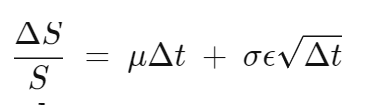

-Price returns are normally distributed.
-Price levels are lognormally distributed.

In [18]:


# Parameters
''' 
n_assets = 3  # Number of companies/assets
mu = np.array([0.05, 0.07, 0.03])  # Expected returns for each asset
sigma = np.array([0.2, 0.25, 0.15])  # Volatilities for each asset
cov_matrix = np.array([
    [0.04, 0.01, 0.02],  # Covariances between assets
    [0.01, 0.0625, 0.015],
    [0.02, 0.015, 0.0225]
])
S0 = np.array([100, 120, 80])  # Initial prices for each asset
'''
n_assets = len(meanReturns)
mu = np.array(meanReturns)
sigma = np.array(sigma)
S0 = np.array([100 for _ in range(n_assets)])
T = 31/365  # Time horizon (in years)
n_steps = 31  # Number of time - steps one per day
n_simulations = 1000  # Number of simulations

# Time step size
dt = T / n_steps

# Cholesky decomposition for correlated random variables
chol_matrix = np.linalg.cholesky(np.array(covMatrix))

# Simulate GBM for multiple assets
def simulate_multi_gbm(S0, mu, sigma, chol_matrix, T, n_steps, n_simulations):
    n_assets = len(S0)
    prices = np.zeros((n_steps + 1, n_assets, n_simulations))
    prices[0] = S0[:, None]  # Set initial prices for all simulations

    # Generate random shocks
    random_shocks = np.random.normal(0, 1, (n_steps, n_assets, n_simulations))
    correlated_shocks = np.einsum('ij,tmj->tmi', chol_matrix, random_shocks)


    # Simulate price paths
    for t in range(1, n_steps + 1):
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * correlated_shocks[t - 1]
        prices[t] = prices[t - 1] * np.exp(drift[:, None] + diffusion)

    return prices

# Run the simulation
simulated_prices = simulate_multi_gbm(S0, mu, sigma, chol_matrix, T, n_steps, n_simulations)

# Visualization
plt.figure(figsize=(10, 6))
for i in range(n_assets):
    plt.plot(simulated_prices[:, i, :10], lw=0.8, label=f'Asset {i+1}')
plt.title("Monte Carlo Simulation of Multi-Asset GBM")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.legend()
plt.show()

# Optional: Portfolio Analysis
# Example: Expected final portfolio value with equal weights
weights = weights  # Portfolio weights for each asset
final_prices = simulated_prices[-1]
portfolio_values = np.dot(final_prices.T, weights)
expected_portfolio_value = np.mean(portfolio_values)
print(f"Expected Final Portfolio Value: {expected_portfolio_value:.2f}")


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (392,392)->(392,392) (31,392,1000)->(31,392,newaxis,1000) 

In [12]:
#MT Carlo with GBM example 


### WHAT I NEED
''' 
# 1. Parameters and Historical Data
np.random.seed(42)  # For reproducibility

# Sample data: assume 3 stocks with their historical mean  and volatilities
stock_data = {
    "Stock A": {"mu": 0.12, "sigma": 0.2},
    "Stock B": {"mu": 0.08, "sigma": 0.15},
    "Stock C": {"mu": 0.10, "sigma": 0.18},
}

'''



stocks = list(stock_data.keys())
initial_prices = [100 for i in range(len(stocks))]  # Starting prices of the stocks
print(initial_prices)
time_horizon = 1  # 1 year
num_steps = 252  # Trading days in a year
num_simulations = 1000  # Monte Carlo simulations



### CODE PART
# 2. Simulating GBM
def simulate_gbm(mu, sigma, S0, T, steps, sims):
    dt = T / steps
    prices = np.zeros((steps + 1, sims))
    prices[0] = S0

    for t in range(1, steps + 1):
        Z = np.random.standard_normal(sims)  # Random normal variables
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return prices



# Simulate price paths for each stock
simulated_prices = {}
for stock, params in stock_data.items():
    simulated_prices[stock] = simulate_gbm(params["mu"], params["sigma"], 100, time_horizon, num_steps, num_simulations)



# 3. Portfolio Simulation
''' 
def simulate_portfolios(num_portfolios, simulated_prices, risk_free_rate=0.03):
    num_stocks = len(simulated_prices)
    final_prices = np.array([simulated_prices[stock][-1] for stock in stocks])  # Final prices from simulations
    expected_returns = final_prices.mean(axis=1) / 100 - 1  # Annualized 
    cov_matrix = np.cov(final_prices / 100)  # Covariance of final prices

    results = {
        "weights": [],
        "": [],
        "volatility": [],
        "sharpe_ratios": []
    }

    for _ in range(num_portfolios):
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)  # Normalize weights to sum to 1

        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

        results["weights"].append(weights)
        results[""].append(portfolio_return)
        results["volatility"].append(portfolio_volatility)
        results["sharpe_ratios"].append(sharpe_ratio)
    
    return results

    
num_portfolios = 10000
portfolio_results = simulate_portfolios(num_portfolios, simulated_prices)

# 4. Optimal Portfolio   dado pelo ERC
max_sharpe_idx = np.argmax(erc_portfolio["sharpe_ratio"])
print(max_sharpe_idx)
optimal_weights = erc_portfolio["weights"][max_sharpe_idx]
optimal_return = erc_portfolio["return"][max_sharpe_idx]
optimal_volatility = erc_portfolio["volatility"][max_sharpe_idx]


# 5. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(
    erc_portfolio["volatility"],
    erc_portfolio["returns"],
    c=erc_portfolio["sharpe_ratios"],
    cmap="viridis",
    alpha=0.6,
)
plt.colorbar(label="Sharpe Ratio")
plt.scatter(optimal_volatility, optimal_return, c="red", marker="*", s=200, label="Optimal Portfolio")
plt.title("Portfolio Optimization: Risk vs Return")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.legend()
plt.show()


# 6. Display Optimal Portfolio
print("Optimal Portfolio Allocation:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {optimal_weights[i]*100:.2f}%")
print(f"Expected Return: {optimal_return*100:.2f}%, Volatility: {optimal_volatility*100:.2f}%, Sharpe Ratio: {erc_portfolio['sharpe_ratios'][max_sharpe_idx]:.2f}")

'''

# 3. Portfolio Simulation with ERC
def simulate_portfolios_with_erc(simulated_prices, risk_free_rate=0.03):
    num_stocks = len(simulated_prices)
    final_prices = np.array([simulated_prices[stock][-1] for stock in stocks])  # Final prices from simulations
    expected_returns = final_prices.mean(axis=1) / 100 - 1  # Annualized 
    cov_matrix = np.cov(final_prices / 100)  # Covariance of final prices

    # Calculate ERC weights
    erc_weights = get_erc_weights_3(cov_matrix)

    # Evaluate the ERC portfolio
    portfolio_return = np.dot(erc_weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(erc_weights.T, np.dot(cov_matrix, erc_weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return {
        "weights": erc_weights,
        "return": portfolio_return,
        "volatility": portfolio_volatility,
        "sharpe_ratio": sharpe_ratio,
    }



# Calculate ERC Portfolio
erc_portfolio = simulate_portfolios_with_erc(simulated_prices)
print("ERC Portfolio Allocation:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {erc_portfolio['weights'][i]*100:.2f}%")
print(f"Expected Return: {erc_portfolio['return']*100:.2f}%, Volatility: {erc_portfolio['volatility']*100:.2f}%, Sharpe Ratio: {erc_portfolio['sharpe_ratio']:.2f}")




[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

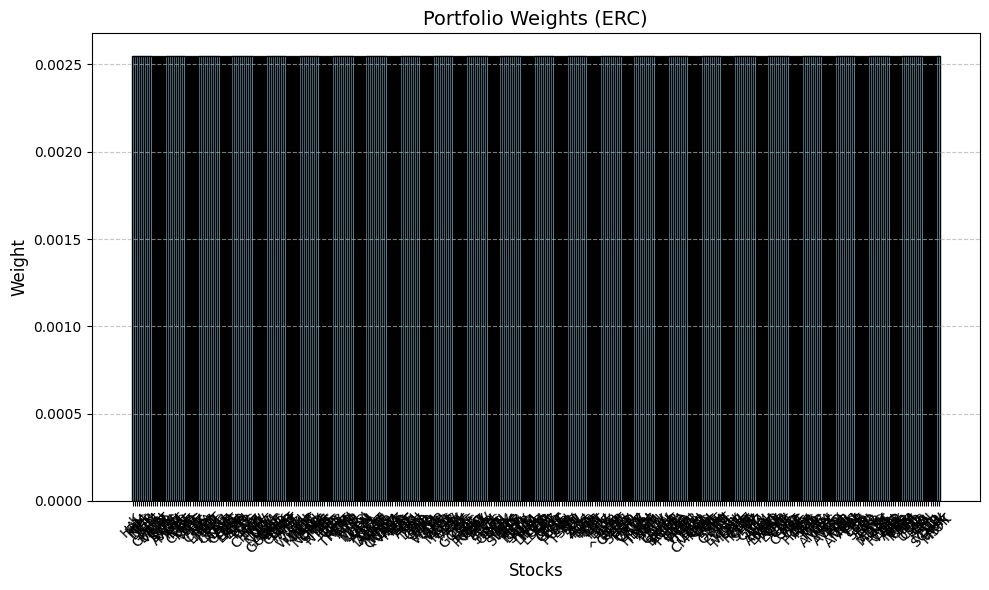

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weights(weights, stock_names):
    plt.figure(figsize=(10, 6))
    plt.bar(stock_names, weights, color='skyblue', edgecolor='black')
    plt.title("Portfolio Weights (ERC)", fontsize=14)
    plt.xlabel("Stocks", fontsize=12)
    plt.ylabel("Weight", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_weights(erc_portfolio["weights"], stocks)


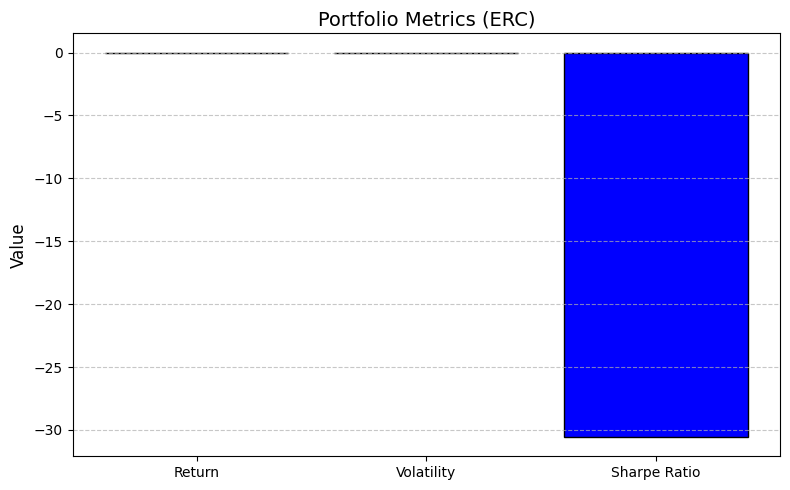

In [16]:
def plot_metrics(results):
    metrics = ["Return", "Volatility", "Sharpe Ratio"]
    values = [results["return"], results["volatility"], results["sharpe_ratio"]]
    
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values, color=['green', 'orange', 'blue'], edgecolor='black')
    plt.title("Portfolio Metrics (ERC)", fontsize=14)
    plt.ylabel("Value", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metrics(erc_portfolio)


In [ ]:
def plot_simulated_prices(simulated_prices, stock_names):
    plt.figure(figsize=(12, 7))
    for stock, prices in simulated_prices.items():
        plt.plot(prices, label=stock)
    plt.title("Simulated Stock Prices", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(stock_names, fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_simulated_prices(simulated_prices, stocks)


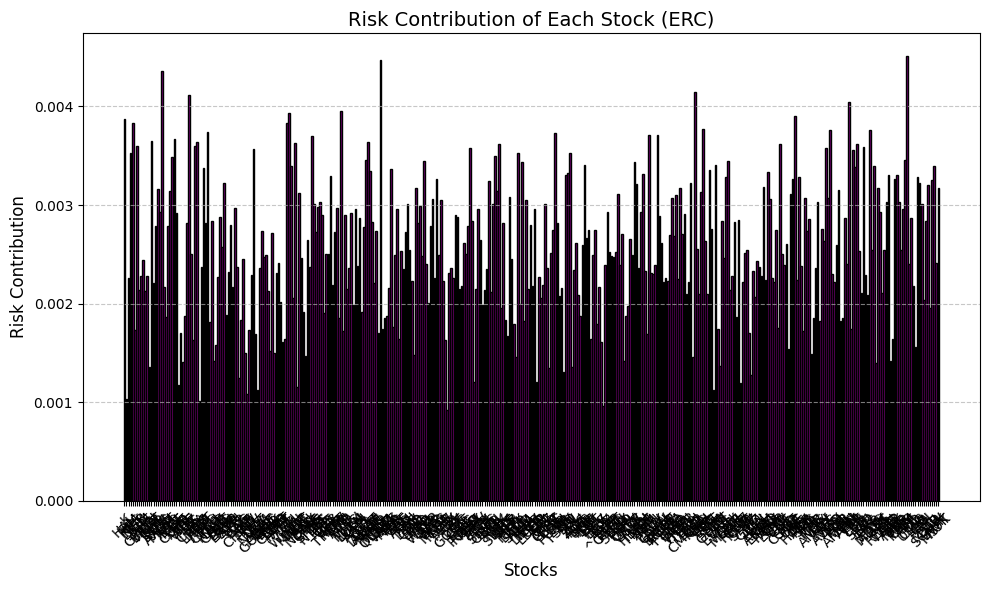

In [13]:
def plot_risk_contribution(weights, cov_matrix, stock_names):
    total_portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    marginal_risk_contribution = np.dot(cov_matrix, weights) / total_portfolio_variance
    risk_contribution = weights * marginal_risk_contribution  # Component-wise
    
    plt.figure(figsize=(10, 6))
    plt.bar(stock_names, risk_contribution, color='purple', edgecolor='black')
    plt.title("Risk Contribution of Each Stock (ERC)", fontsize=14)
    plt.xlabel("Stocks", fontsize=12)
    plt.ylabel("Risk Contribution", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_risk_contribution(erc_portfolio["weights"], covMatrix, stocks)


In [6]:
#value of risk and conditional value of risk

def mcVar(returns, alpha = 5):
    ''' 
    input: pandas series of returns 
    output: percentile on return distribution to a given confidence level alpha
    '''

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")


def mcCVar(returns, alpha = 5):
    ''' 
    input: pandas series of returns 
    output: CVar or Expected Shortfall to a given confidence level alpha
    '''

    if isinstance(returns, pd.Series):
        belowVar = returns <= mcVar(returns, alpha=alpha)
        return returns[belowVar].mean()
    else:
        raise TypeError("Expected a pandas data series.")
    

portResults = pd.Series(portfolio_sins[-1,:])

VaR = initialPortfolio - mcVar(portResults, alpha=5)
CVaR = initialPortfolio - mcCVar(portResults, alpha=5)

print(f'Var ${format(round(VaR, 2))}')  #limite (o valor esperado a perder quando fazer inicial - variancia)
print(f'Var ${format(round(CVaR, 2))}') #risco conditional risc (para baixo do valor obtido em cima)

Var $480.85
Var $671.78


------------
Automating the Monte Carlo Simulations and Showing CAPM Metrics
------------

----------
## References

> https://youtu.be/-4KsB8al4Yo

> https://www.forbes.com/advisor/investing/stocks-vs-bonds/

> https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662

> https://journals.ue.wroc.pl/fins/article/download/138/7/458

> https://youtu.be/f9MAFvP5-pA

> http://thierry-roncalli.com/download/erc-slides.pdf

> https://en.wikipedia.org/wiki/Geometric_Brownian_motion

> https://youtu.be/YZL2xdhh7qE

> https://blog.quantinsti.com/portfolio-optimization-maximum-return-risk-ratio-python/

> https://www.investopedia.com/articles/07/montecarlo.asp

> https://skfolio.org/auto_examples/1_mean_risk/plot_4_mean_variance_cdar.html
